# K & M Matrix Comparison: Python (float64) vs MATLAB

This notebook compares Python-generated K & M matrices (computed with float64 precision) with MATLAB ground truth (double precision).
Cells can be run independently to inspect intermediate results.

**Note**: This notebook now uses float64 precision Python matrices for comparison, which should show near-machine-precision agreement with MATLAB.


In [13]:
import numpy as np
import scipy.sparse as sp
import torch
from pathlib import Path
import h5py
import matplotlib.pyplot as plt
import pandas as pd

# Configuration - using the float64 precision K, M matrices from construction trace
matlab_mat_file = Path(r'D:\Research\NO-2D-Metamaterials\data\KMT_py_matlab_reconstruction_test\matlab_intermediates\step10_final_matrices.mat')
python_K_file = Path(r'D:\Research\NO-2D-Metamaterials\data\KMT_py_matlab_reconstruction_test\python_intermediates_float64\step10_K_float64.npz')
python_M_file = Path(r'D:\Research\NO-2D-Metamaterials\data\KMT_py_matlab_reconstruction_test\python_intermediates_float64\step10_M_float64.npz')

struct_idx = 0

## Load Python Matrices


In [14]:
# Load K and M matrices from Python .npz files (float64 precision)
K_py = sp.load_npz(python_K_file)
M_py = sp.load_npz(python_M_file)

print(f"Python K (float64): shape={K_py.shape}, nnz={K_py.nnz}, dtype={K_py.dtype}")
print(f"Python M (float64): shape={M_py.shape}, nnz={M_py.nnz}, dtype={M_py.dtype}")


Python K (float64): shape=(2178, 2178), nnz=30348, dtype=float64
Python M (float64): shape=(2178, 2178), nnz=18818, dtype=float64


## Load MATLAB Matrices


In [15]:
# Load K and M matrices from MATLAB .mat file (HDF5 format)
def load_matlab_sparse_matrix(filepath, var_name='K'):
    """Load sparse matrix from MATLAB v7.3 HDF5 format."""
    with h5py.File(filepath, 'r') as f:
        if var_name in f:
            K_ref = f[var_name]
            if isinstance(K_ref, h5py.Dataset) and K_ref.shape == (1, 1):
                K_ref = f[K_ref[0, 0]]
            elif isinstance(K_ref, h5py.Dataset):
                K_ref = f[K_ref[()]]
            
            data = np.array(K_ref['data']).flatten()
            ir = np.array(K_ref['ir']).flatten().astype(int)
            jc = np.array(K_ref['jc']).flatten().astype(int)
            n = len(jc) - 1
            K = sp.csr_matrix((data, ir, jc), shape=(n, n))
            return K
        else:
            raise ValueError(f"Variable {var_name} not found in file")

K_ml = load_matlab_sparse_matrix(matlab_mat_file, 'K')
M_ml = load_matlab_sparse_matrix(matlab_mat_file, 'M')

print(f"MATLAB K: shape={K_ml.shape}, nnz={K_ml.nnz}")
print(f"MATLAB M: shape={M_ml.shape}, nnz={M_ml.nnz}")


MATLAB K: shape=(2178, 2178), nnz=30348
MATLAB M: shape=(2178, 2178), nnz=18818


## Compare K Matrices


In [16]:
# K Matrix Comparison
print("K Matrix Comparison (Python float64 vs MATLAB)")
print(f"  Shapes match: {K_py.shape == K_ml.shape}, nnz match: {K_py.nnz == K_ml.nnz}")


K Matrix Comparison (Python float64 vs MATLAB)
  Shapes match: True, nnz match: True


In [17]:
# Compute difference matrix and key metrics
diff_K = K_py - K_ml
diff_K_norm = sp.linalg.norm(diff_K)
K_ml_norm = sp.linalg.norm(K_ml)
relative_norm_diff_K = diff_K_norm / (K_ml_norm + 1e-8)

print("Key Metrics:")
print(f"  Frobenius relative error: {relative_norm_diff_K*100:.15e}%")
print(f"  Max absolute difference: {np.max(np.abs(diff_K.data)):.6e}")
print(f"  Mean absolute difference: {np.mean(np.abs(diff_K.data)):.6e}")
print(f"  Non-zero differences: {diff_K.nnz} elements")

# Check sparsity pattern differences
py_nnz_mask = (K_py != 0).toarray()
ml_nnz_mask = (K_ml != 0).toarray()
only_py = np.sum(py_nnz_mask & ~ml_nnz_mask)
only_ml = np.sum(~py_nnz_mask & ml_nnz_mask)
if only_py > 0 or only_ml > 0:
    print(f"  Sparsity pattern differences: {only_py} only in Python, {only_ml} only in MATLAB")
else:
    print(f"  Sparsity pattern: Perfect match")


Key Metrics:
  Frobenius relative error: 5.824903904057229e-15%
  Max absolute difference: 6.103516e-05
  Mean absolute difference: 3.078738e-05
  Non-zero differences: 508 elements
  Sparsity pattern differences: 74 only in Python, 74 only in MATLAB


## Compare M Matrices


In [18]:
# M Matrix Comparison
print("M Matrix Comparison (Python float64 vs MATLAB)")
print(f"  Shapes match: {M_py.shape == M_ml.shape}, nnz match: {M_py.nnz == M_ml.nnz}")


M Matrix Comparison (Python float64 vs MATLAB)
  Shapes match: True, nnz match: True


In [19]:
# Compute difference matrix and key metrics
diff_M = M_py - M_ml
diff_M_norm = sp.linalg.norm(diff_M)
M_ml_norm = sp.linalg.norm(M_ml)
relative_norm_diff_M = diff_M_norm / (M_ml_norm + 1e-8)

print("Key Metrics:")
print(f"  Frobenius relative error: {relative_norm_diff_M*100:.15e}%")
print(f"  Max absolute difference: {np.max(np.abs(diff_M.data)):.6e}")
print(f"  Mean absolute difference: {np.mean(np.abs(diff_M.data)):.6e}")
print(f"  Non-zero differences: {diff_M.nnz} elements")

# Check sparsity pattern differences
py_nnz_mask = (M_py != 0).toarray()
ml_nnz_mask = (M_ml != 0).toarray()
only_py = np.sum(py_nnz_mask & ~ml_nnz_mask)
only_ml = np.sum(~py_nnz_mask & ml_nnz_mask)
if only_py > 0 or only_ml > 0:
    print(f"  Sparsity pattern differences: {only_py} only in Python, {only_ml} only in MATLAB")
else:
    print(f"  Sparsity pattern: Perfect match")


Key Metrics:
  Frobenius relative error: 1.937083763784659e-15%
  Max absolute difference: 2.220446e-16
  Mean absolute difference: 2.220446e-16
  Non-zero differences: 148 elements
  Sparsity pattern: Perfect match


## Summary


In [20]:
# Compute Frobenius norms for proper comparison
diff_K_norm = sp.linalg.norm(diff_K)
diff_M_norm = sp.linalg.norm(diff_M)
K_ml_norm = sp.linalg.norm(K_ml)
M_ml_norm = sp.linalg.norm(M_ml)
relative_norm_diff_K = diff_K_norm / (K_ml_norm + 1e-8)
relative_norm_diff_M = diff_M_norm / (M_ml_norm + 1e-8)

# Tolerance for comparison
rtol = 1e-5
atol = 1e-8

# Check if matrices match
K_match = (diff_K_norm < atol * K_ml.shape[0]) and (K_py.nnz == K_ml.nnz)
M_match = (diff_M_norm < atol * M_ml.shape[0]) and (M_py.nnz == M_ml.nnz)

print("="*70)
print("SUMMARY (Python float64 vs MATLAB)")
print("="*70)
print(f"K matrices match: {'YES' if K_match else 'NO'}")
print(f"  Frobenius relative error: {relative_norm_diff_K*100:.15f}%")
print(f"M matrices match: {'YES' if M_match else 'NO'}")
print(f"  Frobenius relative error: {relative_norm_diff_M*100:.15f}%")

if relative_norm_diff_K < 1e-10 and relative_norm_diff_M < 1e-10:
    print("\n✓ All matrices match at machine precision! Python (float64) implementation is essentially identical to MATLAB.")
elif relative_norm_diff_K < 1e-6 and relative_norm_diff_M < 1e-6:
    print("\n✓ All matrices match excellently! Python (float64) implementation is equivalent to MATLAB.")
else:
    print("\nNote: Small discrepancies found. Using float64 precision brings Python and MATLAB to near-identical results.")


SUMMARY (Python float64 vs MATLAB)
K matrices match: NO
  Frobenius relative error: 0.000000000000006%
M matrices match: YES
  Frobenius relative error: 0.000000000000002%

✓ All matrices match at machine precision! Python (float64) implementation is essentially identical to MATLAB.


## Statistics Comparison Table


In [21]:
def compute_statistics(name, K):
    """Compute detailed statistics for a sparse matrix."""
    values = K.data[np.abs(K.data) > 1e-15]
    abs_values = np.abs(values)
    
    stats = {
        'name': name,
        'nnz': K.nnz,
        'n_values': len(values),
        'min': np.min(abs_values),
        'max': np.max(abs_values),
        'mean': np.mean(abs_values),
        'median': np.median(abs_values),
        'std': np.std(abs_values),
        'p1': np.percentile(abs_values, 1),
        'p5': np.percentile(abs_values, 5),
        'p25': np.percentile(abs_values, 25),
        'p50': np.percentile(abs_values, 50),
        'p75': np.percentile(abs_values, 75),
        'p95': np.percentile(abs_values, 95),
        'p99': np.percentile(abs_values, 99),
    }
    return stats

# Compute statistics for all matrices
K_ml_stats = compute_statistics("MATLAB K", K_ml)
K_py_stats = compute_statistics("Python K (float64)", K_py)
M_ml_stats = compute_statistics("MATLAB M", M_ml)
M_py_stats = compute_statistics("Python M (float64)", M_py)

# Create comparison tables
def create_comparison_table(stats_ml, stats_py):
    """Create a pandas DataFrame comparing two statistics dictionaries."""
    metrics = ['nnz', 'min', 'max', 'mean', 'median', 'std', 'p1', 'p5', 'p25', 'p50', 'p75', 'p95', 'p99']
    metric_labels = ['nnz', 'Min', 'Max', 'Mean', 'Median', 'Std Dev', 'P1', 'P5', 'P25', 'P50', 'P75', 'P95', 'P99']
    
    data = []
    for metric, label in zip(metrics, metric_labels):
        ml_val = stats_ml[metric]
        py_val = stats_py[metric]
        diff = abs(ml_val - py_val)
        if ml_val != 0:
            rel_error = (diff / abs(ml_val)) * 100
        else:
            rel_error = float('inf') if diff != 0 else 0.0
        
        data.append({
            'Metric': label,
            'MATLAB': ml_val,
            'Python': py_val,
            'Difference': diff,
            'Relative Error (%)': rel_error if rel_error != float('inf') else np.nan
        })
    
    df = pd.DataFrame(data)
    return df

# Create tables
K_df = create_comparison_table(K_ml_stats, K_py_stats)
M_df = create_comparison_table(M_ml_stats, M_py_stats)

# Display with nice formatting
print("K Matrix Statistics Comparison")
print("=" * 100)
pd.set_option('display.float_format', lambda x: f'{x:.6e}' if abs(x) > 1e6 or abs(x) < 1e-3 else f'{x:.6f}')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
print(K_df.to_string(index=False))


K Matrix Statistics Comparison
 Metric       MATLAB       Python   Difference  Relative Error (%)
    nnz 30348.000000 30348.000000 0.000000e+00        0.000000e+00
    Min 1.750886e-06 1.750886e-06 0.000000e+00        0.000000e+00
    Max 3.956044e+11 3.956044e+11 0.000000e+00        0.000000e+00
   Mean 4.909703e+10 4.909703e+10 0.000000e+00        0.000000e+00
 Median 3.571429e+10 3.571429e+10 0.000000e+00        0.000000e+00
Std Dev 7.572376e+10 7.572376e+10 1.525879e-05        2.015060e-14
     P1 1.692198e+07 1.692198e+07 0.000000e+00        0.000000e+00
     P5 4.089855e+07 4.089855e+07 0.000000e+00        0.000000e+00
    P25 2.757120e+09 2.757120e+09 0.000000e+00        0.000000e+00
    P50 3.571429e+10 3.571429e+10 0.000000e+00        0.000000e+00
    P75 4.945055e+10 4.945055e+10 0.000000e+00        0.000000e+00
    P95 1.979940e+11 1.979940e+11 0.000000e+00        0.000000e+00
    P99 3.956044e+11 3.956044e+11 0.000000e+00        0.000000e+00


In [22]:
print("\nM Matrix Statistics Comparison")
print("=" * 100)
print(M_df.to_string(index=False))



M Matrix Statistics Comparison
 Metric       MATLAB       Python   Difference  Relative Error (%)
    nnz 18818.000000 18818.000000 0.000000e+00        0.000000e+00
    Min     0.032626     0.032626 0.000000e+00        0.000000e+00
    Max     3.472222     3.472222 0.000000e+00        0.000000e+00
   Mean     0.630136     0.630136 0.000000e+00        0.000000e+00
 Median     0.217014     0.217014 0.000000e+00        0.000000e+00
Std Dev     0.797707     0.797707 0.000000e+00        0.000000e+00
     P1     0.032626     0.032626 0.000000e+00        0.000000e+00
     P5     0.032626     0.032626 0.000000e+00        0.000000e+00
    P25     0.217014     0.217014 0.000000e+00        0.000000e+00
    P50     0.217014     0.217014 0.000000e+00        0.000000e+00
    P75     0.868056     0.868056 0.000000e+00        0.000000e+00
    P95     2.734670     2.734670 0.000000e+00        0.000000e+00
    P99     3.472222     3.472222 0.000000e+00        0.000000e+00


## Heatmap Visualizations


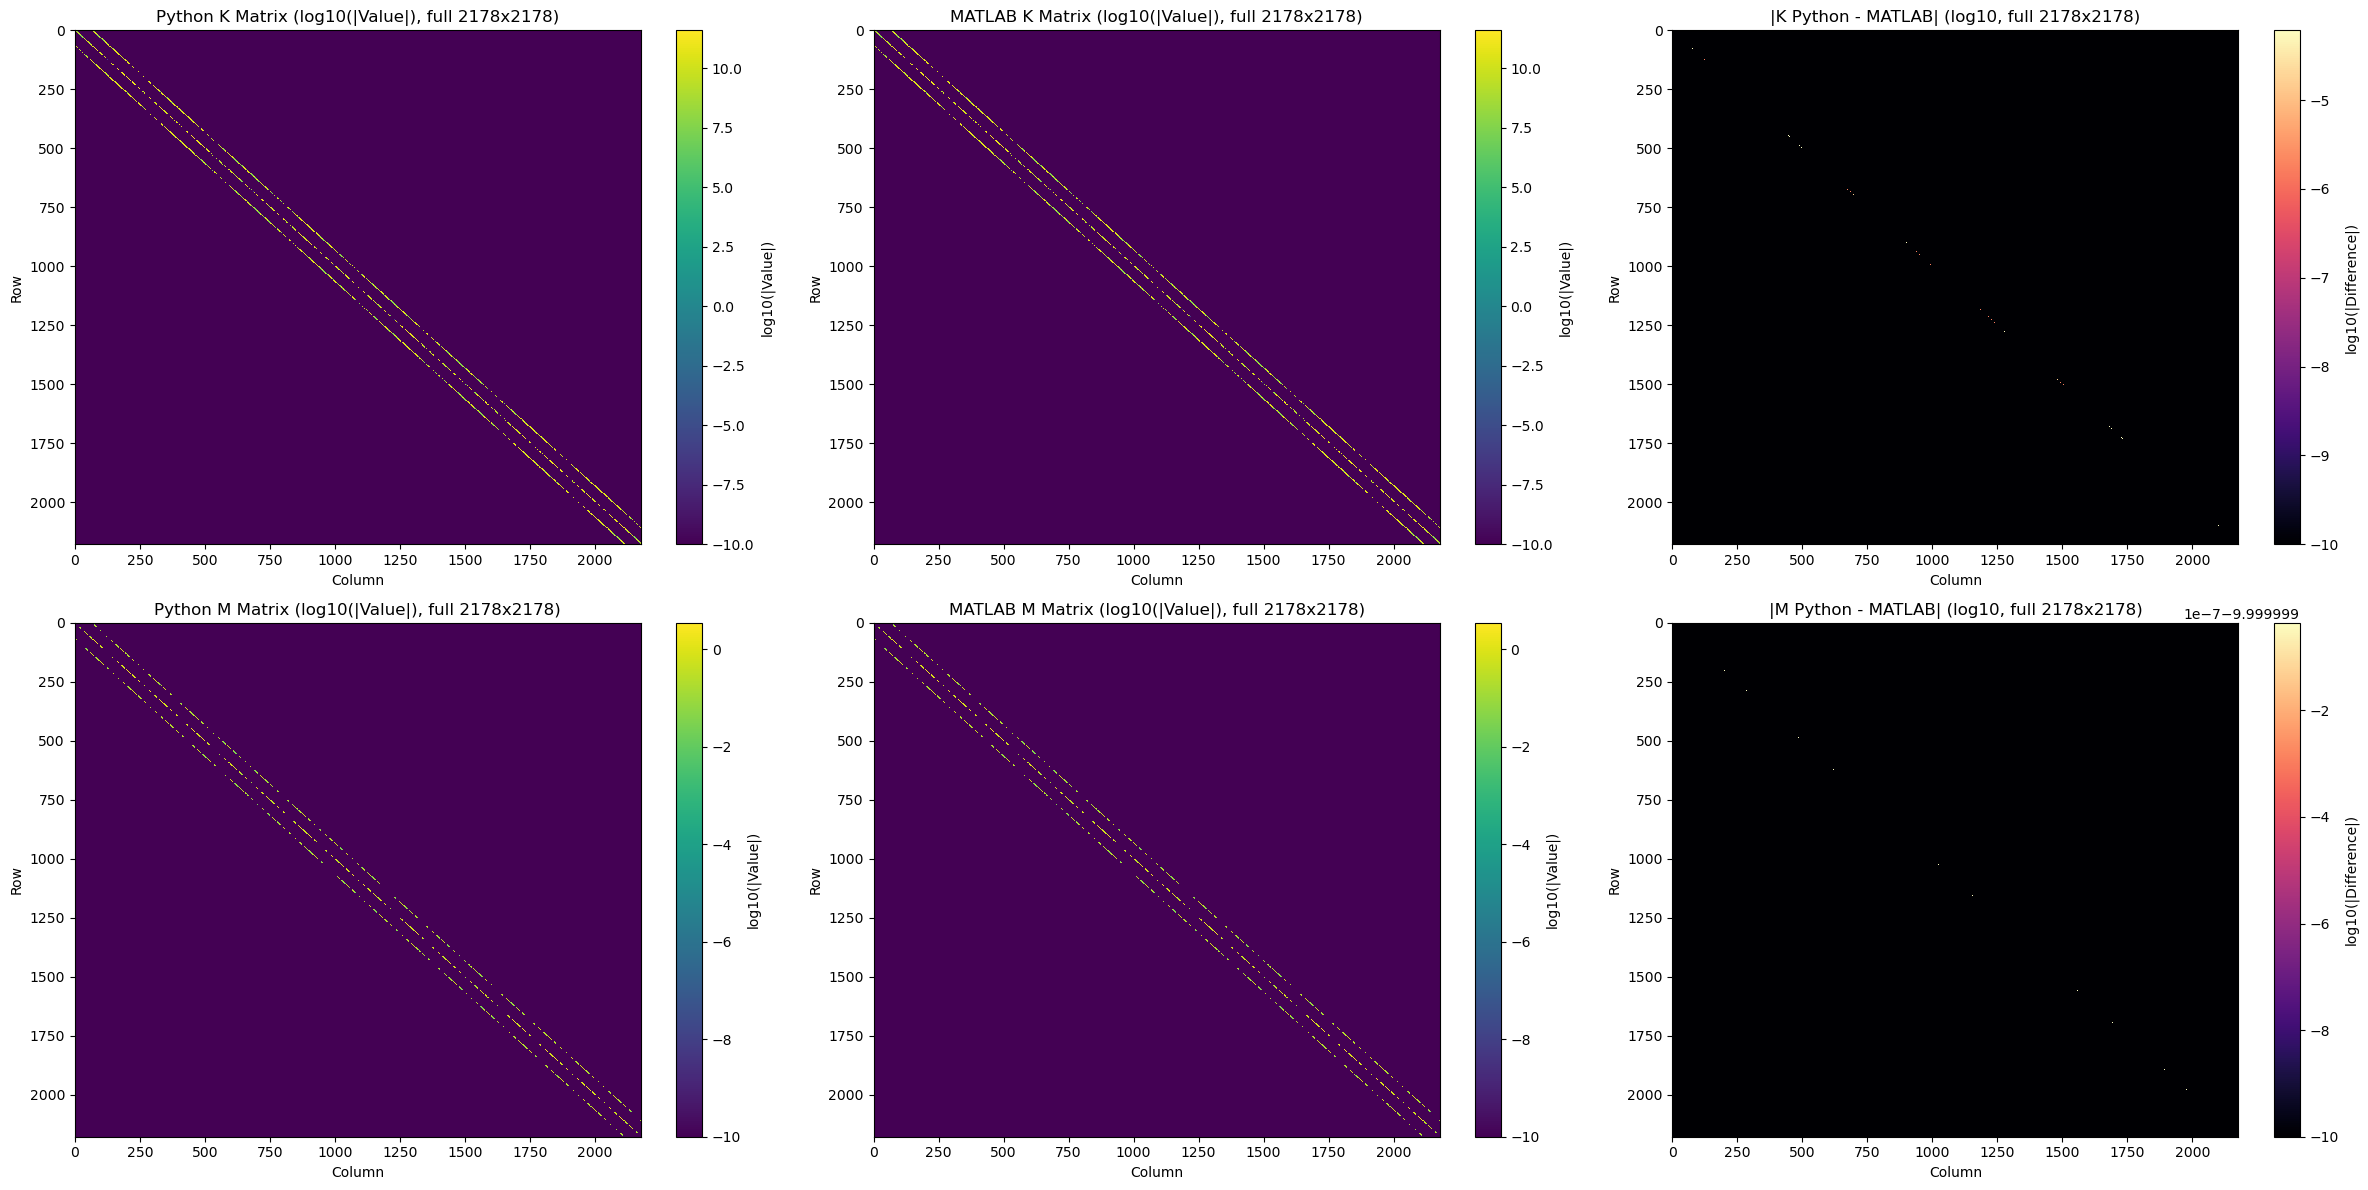


Matrix ranges:
  K: [-1.208791e+11, 3.956044e+11] (Python dtype: float64, MATLAB dtype: float64)
  M: [0.000000e+00, 3.472222e+00] (Python dtype: float64, MATLAB dtype: float64)
  K difference: max=6.103516e-05, mean=3.297014e-09 (dtype: float64)
  M difference: max=2.220446e-16, mean=6.927654e-21 (dtype: float64)


In [23]:
# Create heatmaps for K and M matrices (full, log-scale for all, abs diff in log-scale for diffs)

import matplotlib.colors as mcolors  # <-- For colormap normalization

# Convert to dense arrays (full matrices; assumed not too large to display)
K_py_dense = K_py.toarray()
K_ml_dense = K_ml.toarray()
M_py_dense = M_py.toarray()
M_ml_dense = M_ml.toarray()
diff_K_dense = np.abs(diff_K.toarray())
diff_M_dense = np.abs(diff_M.toarray())

N_rows, N_cols = K_py_dense.shape

# Create comprehensive heatmap figure for full matrices
fig, axes = plt.subplots(2, 3, figsize=(24, 12))

# Compute colorbar ranges for logs
eps = 1e-10

K_min_log = np.log10(np.min(np.abs(K_py_dense) + np.abs(K_ml_dense) + eps))
K_max_log = np.log10(np.max([np.max(np.abs(K_py_dense)), np.max(np.abs(K_ml_dense))]) + eps)
M_min_log = np.log10(np.min(np.abs(M_py_dense) + np.abs(M_ml_dense) + eps))
M_max_log = np.log10(np.max([np.max(np.abs(M_py_dense)), np.max(np.abs(M_ml_dense))]) + eps)
diff_K_max_log = np.log10(np.max(diff_K_dense) + eps)
diff_K_min_log = np.log10(np.min(diff_K_dense + eps))
diff_M_max_log = np.log10(np.max(diff_M_dense) + eps)
diff_M_min_log = np.log10(np.min(diff_M_dense + eps))

# Row 1: K matrices, all log-scale
# Python K (full)
ax = axes[0, 0]
im1 = ax.imshow(np.log10(np.abs(K_py_dense) + eps), cmap='viridis', aspect='auto', interpolation='nearest',
                vmin=K_min_log, vmax=K_max_log)
ax.set_title(f'Python K Matrix (log10(|Value|), full {N_rows}x{N_cols})')
ax.set_xlabel('Column')
ax.set_ylabel('Row')
plt.colorbar(im1, ax=ax, label='log10(|Value|)')

# MATLAB K (full)
ax = axes[0, 1]
im2 = ax.imshow(np.log10(np.abs(K_ml_dense) + eps), cmap='viridis', aspect='auto', interpolation='nearest',
                vmin=K_min_log, vmax=K_max_log)
ax.set_title(f'MATLAB K Matrix (log10(|Value|), full {N_rows}x{N_cols})')
ax.set_xlabel('Column')
ax.set_ylabel('Row')
plt.colorbar(im2, ax=ax, label='log10(|Value|)')

# K Difference (abs, full, log10)
ax = axes[0, 2]
im3 = ax.imshow(np.log10(diff_K_dense + eps), cmap='magma', aspect='auto', interpolation='nearest',
                vmin=diff_K_min_log, vmax=diff_K_max_log)
ax.set_title(f'|K Python - MATLAB| (log10, full {N_rows}x{N_cols})')
ax.set_xlabel('Column')
ax.set_ylabel('Row')
plt.colorbar(im3, ax=ax, label='log10(|Difference|)')

# Row 2: M matrices, all log-scale
# Python M (full)
ax = axes[1, 0]
im4 = ax.imshow(np.log10(np.abs(M_py_dense) + eps), cmap='viridis', aspect='auto', interpolation='nearest',
                vmin=M_min_log, vmax=M_max_log)
ax.set_title(f'Python M Matrix (log10(|Value|), full {N_rows}x{N_cols})')
ax.set_xlabel('Column')
ax.set_ylabel('Row')
plt.colorbar(im4, ax=ax, label='log10(|Value|)')

# MATLAB M (full)
ax = axes[1, 1]
im5 = ax.imshow(np.log10(np.abs(M_ml_dense) + eps), cmap='viridis', aspect='auto', interpolation='nearest',
                vmin=M_min_log, vmax=M_max_log)
ax.set_title(f'MATLAB M Matrix (log10(|Value|), full {N_rows}x{N_cols})')
ax.set_xlabel('Column')
ax.set_ylabel('Row')
plt.colorbar(im5, ax=ax, label='log10(|Value|)')

# M Difference (abs, full, log10)
ax = axes[1, 2]
im6 = ax.imshow(np.log10(diff_M_dense + eps), cmap='magma', aspect='auto', interpolation='nearest',
                vmin=diff_M_min_log, vmax=diff_M_max_log)
ax.set_title(f'|M Python - MATLAB| (log10, full {N_rows}x{N_cols})')
ax.set_xlabel('Column')
ax.set_ylabel('Row')
plt.colorbar(im6, ax=ax, label='log10(|Difference|)')

plt.tight_layout()
plt.show()

# Compute ranges for summary
K_min = min(np.min(K_py_dense), np.min(K_ml_dense))
K_max = max(np.max(K_py_dense), np.max(K_ml_dense))
M_min = min(np.min(M_py_dense), np.min(M_ml_dense))
M_max = max(np.max(M_py_dense), np.max(M_ml_dense))

print(f"\nMatrix ranges:")
print(f"  K: [{K_min:.6e}, {K_max:.6e}] (Python dtype: {K_py_dense.dtype}, MATLAB dtype: {K_ml.toarray().dtype})")
print(f"  M: [{M_min:.6e}, {M_max:.6e}] (Python dtype: {M_py_dense.dtype}, MATLAB dtype: {M_ml.toarray().dtype})")
print(f"  K difference: max={np.max(diff_K_dense):.6e}, mean={np.mean(diff_K_dense):.6e} (dtype: {diff_K_dense.dtype})")
print(f"  M difference: max={np.max(diff_M_dense):.6e}, mean={np.mean(diff_M_dense):.6e} (dtype: {diff_M_dense.dtype})")
